In [1]:
import numpy as np
import cv2
import time
import os
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip


In [2]:
weights_path = os.path.join("yolov3.weights")
config_path = os.path.join("yolov3.cfg")

net = cv2.dnn.readNetFromDarknet(config_path, weights_path)


In [3]:
names = net.getLayerNames()
print(names)

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

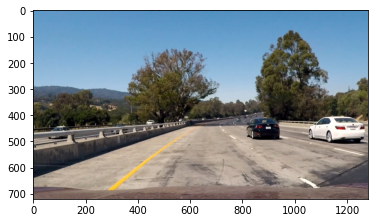

In [4]:
image_path = os.path.join("test_images", "test1.jpg")
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)


In [6]:
(H, W) = img.shape[:2]
print(H, W)


720 1280


In [7]:
layers_names = [names[i - 1] for i in net.getUnconnectedOutLayers()]

layers_names


['yolo_82', 'yolo_94', 'yolo_106']

In [8]:
blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), crop=False, swapRB=False)
net.setInput(blob)
# Calculate run time
start_t = time.time()
layers_output = net.forward(layers_names)
print("A forward pass through yolov3 took {}", format(time.time() - start_t))


A forward pass through yolov3 took {} 0.5320875644683838


In [20]:
layers_output[1].shape


(2028, 85)

In [10]:
boxes = []
confidences = []
classIDs = []


In [11]:
# ((52 x 52) + (26 x 26) + 13 x 13)) x 3 = 10647
for output in layers_output:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        if confidence > 0.85:
            box = detection[:4] * np.array([W, H, W, H])
            bx, by, bw, bh = box.astype("int")

            x = int(bx - (bw / 2))
            y = int(by - (bh / 2))

            boxes.append([x, y, int(bw), int(bh)])
            confidences.append(float(confidence))
            classIDs.append(classID)


In [12]:
labels_path = os.path.join("coco.names")
labels = open(labels_path).read().strip().split("\n")


In [13]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.8, 0.8)


In [14]:
for i in idxs.flatten():
    (x, y) = [boxes[i][0], boxes[i][1]]
    (w, h) = [boxes[i][2], boxes[i][3]]

    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 139, 139), 2)
    cv2.putText(
        img,
        "{}: {}".format(labels[classIDs[i]], confidences[i]),
        (x, y - 5),
        cv2.FONT_HERSHEY_DUPLEX,
        0.5,
        (0, 139, 139),
        1,
    )


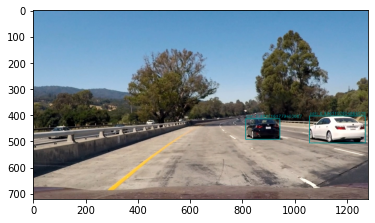

In [15]:
# cv2.imshow("Image" , cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
# cv2.waitKey(0)
plt.imshow(img)


In [ ]:
def final_pipeline(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (H, W) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), crop=False, swapRB=False)
    # net = cv2.dnn.readNetFromDarknet(config_path,weights_path)
    # layers_names = [ names[i-1] for i in net.getUnconnectedOutLayers()  ]

    net.setInput(blob)
    layers_output = net.forward(layers_names)

    boxes = []
    confidences = []
    classIDs = []

    for output in layers_output:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > 0.85:
                box = detection[:4] * np.array([W, H, W, H])
                bx, by, bw, bh = box.astype("int")

                x = int(bx - (bw / 2))
                y = int(by - (bh / 2))

                boxes.append([x, y, int(bw), int(bh)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.8, 0.8)

    if len(idxs) == 0:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # print(idxs.flatten())

    for i in idxs.flatten():
        (x, y) = [boxes[i][0], boxes[i][1]]
        (w, h) = [boxes[i][2], boxes[i][3]]

        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 139, 139), 2)
        cv2.putText(
            img,
            "{}: {}".format(labels[classIDs[i]], confidences[i]),
            (x, y - 5),
            cv2.FONT_HERSHEY_DUPLEX,
            0.5,
            (0, 0, 0),
            1,
        )
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [ ]:
# # read in the project video
input_video_filename = "project_video.mp4"
output_video_filename = "phase2_project_video_result.mp4"
clip = VideoFileClip(input_video_filename).set_fps(15)
clip = clip.fl_image(final_pipeline)
clip.write_videofile(output_video_filename, audio=False)
